# Introduction to Ray Data

This template provides a comprehensive introduction to **Ray Data** — a scalable data processing library for AI workloads built on [Ray](https://docs.ray.io/en/latest/). You will learn what Ray Data is, why it matters for ML pipelines, and how to use its core APIs hands-on with an MNIST image classification example.

In the first half, we'll walk through the core Ray Data workflow — loading, transforming, and persisting data — with concepts explained along the way. The second half covers advanced topics you can explore as your workloads grow.

**Here is the roadmap for this template:**

**Core:**
- **Part 1:** When to Use Ray Data
- **Part 2:** Loading Data
- **Part 3:** Lazy Execution
- **Part 4:** Transforming Data with `map_batches`
- **Part 5:** Stateful Transformations and Batch Inference
- **Part 6:** Data Operations — Groupby, Aggregation
- **Part 7:** Observability
- **Part 8:** Materializing and Persisting Data

**Advanced topics:**
- **Part 9:** Preprocessing and Expressions
- **Part 10:** Shuffling
- **Part 11:** Resource Management and Performance Tuning
- **Part 12:** Fault Tolerance and Checkpointing
- **Summary and Next Steps**

## Imports

In [2]:
import numpy as np
import torch
from torchvision.transforms import Compose, ToTensor, Normalize
from matplotlib import pyplot as plt

import ray

### Note on Storage

Throughout this tutorial, we use `/mnt/cluster_storage` to represent a shared storage location. In a multi-node cluster, Ray workers on different nodes cannot access the head node's local file system. Use a [shared storage solution](https://docs.anyscale.com/configuration/storage#shared) accessible from every node.

## Part 1: When to Use Ray Data

Consider using Ray Data when your project meets one or more of these criteria:

| **Challenge** | **Ray Data Solution** |
|---------------|----------------------|
| **Operating on large datasets** | Distributes data loading and processing across a Ray cluster with streaming execution |
| **Feeding data into distributed training** | Streams data directly to [Ray Train](https://docs.ray.io/en/latest/train/user-guides/data-loading-preprocessing.html) workers with configurable batch sizes — no intermediate disk writes needed. See the **Introduction to Ray Train** template for a hands-on walkthrough. |
| **Running batch inference at scale** | Maximizes GPU utilization by streaming data through model inference actors |
| **Building reliable data pipelines** | Leverages Ray Core's fault-tolerance mechanisms — retries, checkpointing, and recovery |

Ray Data features a **streaming execution engine** that processes data in a pipelined fashion across a heterogeneous cluster of CPUs and GPUs. You write everything in native Python — your existing functions and libraries (NumPy, PyTorch, etc.) work as-is — and Ray Data handles the distribution, avoiding full materialization in memory and keeping all hardware utilized.

To understand why this matters, consider the difference between traditional batch processing and streaming:

**Traditional batch processing** completes one stage fully before starting the next, leading to idle resources:

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/cko-2025-q1/batch-processing.png" width="800" alt="Traditional Batch Processing">

**Streaming pipelining** overlaps stages, keeping all hardware (CPUs and GPUs) busy simultaneously:

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/cko-2025-q1/pipelining.png" width="800" alt="Streaming Model Pipelining">

This is critical for GPU-heavy workloads: while the GPU runs inference on one batch, the CPU can preprocess the next batch.

## Part 2: Loading Data

Ray Data provides built-in connectors for common formats — Parquet, CSV, JSON, images, text — as well as sources such as HuggingFace Datasets, Delta Lake, Iceberg, and in-memory objects (NumPy, Pandas, PyTorch). See the full list in the [Input/Output docs](https://docs.ray.io/en/latest/data/api/input_output.html) and the [data loading guide](https://docs.ray.io/en/latest/data/loading-data.html).

Under the hood, Ray Data uses Ray tasks to read data from remote storage. It creates read tasks proportional to the number of CPUs in your cluster, and each task produces output **blocks**:

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/intro-ai-libraries/dataset-read-many-to-many.png" width="90%">

Let's load MNIST image data from S3:

In [3]:
ds = ray.data.read_images(
    "s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/",
    include_paths=True,
)

2026-02-13 23:59:46,507	INFO worker.py:1821 -- Connecting to existing Ray cluster at address: 10.0.55.63:6379...
2026-02-13 23:59:46,520	INFO worker.py:1998 -- Connected to Ray cluster. View the dashboard at https://session-4m21i7i1x1y6hvvwbhtjq6iv24.i.anyscaleuserdata.com 
2026-02-13 23:59:46,523	INFO packaging.py:463 -- Pushing file package 'gcs://_ray_pkg_6cbb9e1e125ab4ff76982edb0def3f26184a8474.zip' (0.12MiB) to Ray cluster...
2026-02-13 23:59:46,524	INFO packaging.py:476 -- Successfully pushed file package 'gcs://_ray_pkg_6cbb9e1e125ab4ff76982edb0def3f26184a8474.zip'.
/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


A **Dataset** is a distributed collection of **blocks** — contiguous subsets of rows stored as PyArrow tables. Blocks are distributed across the cluster and processed in parallel. They live in the **Ray object store** — shared memory distributed across cluster nodes — so data passes between operators through zero-copy reads. When the object store fills up, Ray spills blocks to disk automatically.

<img src="https://docs.ray.io/en/latest/_images/dataset-arch.svg" width="90%"/>

Since a Dataset is a list of Ray object references, it can be freely passed between Ray tasks, actors, and libraries.

## Part 3: Lazy Execution

In Ray Data, most transformations are **lazy** — they build an execution plan rather than running immediately. The plan executes only when you call a method that *consumes* or *materializes* the dataset.

**Execution-triggering methods include:**

| **Category** | **Methods** |
|-------------|------------|
| Small samples | `take_batch()`, `take()`, `show()` |
| Full materialization | `materialize()` |
| Write to storage | `write_parquet()`, `write_csv()`, etc. |
| Aggregations | `count()`, `mean()`, `min()`, `max()`, `sum()`, `std()` |

To materialize a small subset for inspection, use `take`:

2026-02-13 23:59:47,054	INFO dataset.py:3641 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2026-02-13 23:59:47,058	INFO logging.py:397 -- Registered dataset logger for dataset dataset_34_0
2026-02-13 23:59:47,081	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_34_0. Full logs are in /tmp/ray/session_2026-02-13_23-18-25_427086_2605/logs/ray-data
2026-02-13 23:59:47,082	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_34_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> LimitOperator[limit=5] -> TaskPoolMapOperator[ReadFiles]
2026-02-13 23:59:47,083	INFO streaming_executor.py:687 -- [dataset]: A new progress UI is available. To enable, set `ray.data.DataContext.get_current().enable_rich_progress_bars = True` and `ray.data.DataContext.get_current().use_ray_tqdm = False`.
2026-02-13 23:59:47,083	INFO progress_bar.py:155 -- Progress bar disabled because stdout is a non-intera

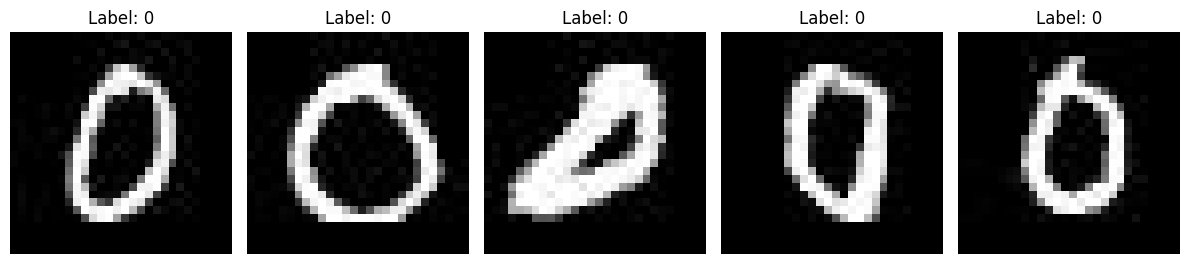

In [4]:
sample = ds.take(5)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax, row in zip(axes, sample):
    label = row["path"].split("/")[-2]
    ax.imshow(row["image"], cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.tight_layout()
plt.show()

This lazy execution model lets Ray Data optimize the full pipeline before running it. When you chain transformations (e.g., `ds.map_batches(f1).map_batches(f2).write_parquet(...)`), Ray Data builds a **logical plan** of your declared operations, then produces an optimized **physical plan**. A key optimization is **operator fusion** — adjacent compatible operators are merged into a single task, reducing data movement between stages. You can use `ds.explain()` to inspect the execution plan (we'll do this in Part 5 once we've built a more interesting pipeline).

For a deeper dive into Ray Data internals, see the [Data Internals guide](https://docs.ray.io/en/latest/data/data-internals.html) and the [Key Concepts page](https://docs.ray.io/en/latest/data/key-concepts.html).

## Part 4: Transforming Data with `map_batches`

The primary transformation API in Ray Data is `map_batches()`. It applies a user-defined function to each batch of data in parallel.

A batch is a `dict[str, np.ndarray]` by default. Your function receives a batch and returns a transformed batch:

In [5]:
def normalize(batch: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    """Normalize MNIST images to [-1, 1] range using torchvision transforms."""
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    batch["image"] = [transform(image) for image in batch["image"]]
    return batch

In [6]:
ds_normalized = ds.map_batches(normalize)  # Lazy — not executed yet

Let's verify the transformation works on a small batch:

In [7]:
normalized_batch = ds_normalized.take_batch(batch_size=10)

for image in normalized_batch["image"]:
    assert image.shape == (1, 28, 28)  # channel, height, width
    assert image.min() >= -1 and image.max() <= 1  # normalized range

2026-02-13 23:59:51,810	INFO logging.py:397 -- Registered dataset logger for dataset dataset_36_0
2026-02-13 23:59:51,816	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_36_0. Full logs are in /tmp/ray/session_2026-02-13_23-18-25_427086_2605/logs/ray-data
2026-02-13 23:59:51,817	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_36_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> LimitOperator[limit=10] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[MapBatches(normalize)]
2026-02-13 23:59:51,834	INFO progress_bar.py:213 -- === Ray Data Progress {ListFiles} ===
2026-02-13 23:59:51,835	INFO progress_bar.py:215 -- ListFiles: Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-02-13 23:59:51,836	INFO progress_bar.py:213 -- === Ray Data Progress {limit=10} ===
2026-02-13 23:59:51,837	INFO progress_bar.py:215 -- limit=10: Tasks: 0; Actors: 0; Queued blocks: 0 (0

In [8]:
# Check the value ranges after normalization
print(f"Shape: {normalized_batch['image'][0].shape}")
print(f"Min value: {normalized_batch['image'][0].min():.4f}")
print(f"Max value: {normalized_batch['image'][0].max():.4f}")

Shape: (1, 28, 28)
Min value: -1.0000
Max value: 1.0000


**Key `map_batches` parameters:**

| **Parameter** | **Purpose** |
|--------------|-------------|
| `batch_size` | Number of rows per batch (default: `None` = entire block) |
| `batch_format` | `"default"`/`"numpy"` (dict), `"pandas"`, or `"pyarrow"` |
| `num_cpus` / `num_gpus` | Resources per worker |
| `fn_kwargs` | Keyword arguments to pass to your function |
| `compute` | Execution strategy — `TaskPoolStrategy` for functions, `ActorPoolStrategy` for classes |

**When to use `map` vs `map_batches`:** Use `map_batches` when the underlying computation is vectorized — for example, NumPy array operations, PyArrow transforms, or GPU inference. If your logic is row-by-row standard Python (such as string parsing or feature extraction), use `map` instead, which applies a function to each row individually and avoids the overhead of batch formatting.

## Part 5: Stateful Transformations and Batch Inference

For operations like batch inference, you want to load a model once and reuse it across many batches. Ray Data supports this via **callable classes** passed to `map_batches`:

- `__init__`: Initialize expensive state (load model, set up connections)
- `__call__`: Process each batch using the initialized state

Here's an MNIST classifier that loads a pre-trained PyTorch model and runs inference:

In [9]:
class MNISTClassifier:
    def __init__(self, model_path: str):
        self.model = torch.jit.load(model_path)
        self.model.eval()

    def __call__(self, batch: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
        images = torch.tensor(batch["image"]).float()

        with torch.no_grad():
            logits = self.model(images).numpy()

        batch["predicted_label"] = np.argmax(logits, axis=1)
        return batch

Download the model to shared storage, then apply the classifier:

In [10]:
!aws s3 cp s3://anyscale-public-materials/ray-ai-libraries/mnist/model/model.pt /mnt/cluster_storage/model.pt

download: s3://anyscale-public-materials/ray-ai-libraries/mnist/model/model.pt to ../../../mnt/cluster_storage/model.pt


In [11]:
ds_preds = ds_normalized.map_batches(
    MNISTClassifier,
    fn_constructor_kwargs={"model_path": "/mnt/cluster_storage/model.pt"},
    num_cpus=1,
    batch_size=100,
    compute=ray.data.ActorPoolStrategy(size=1),
)

**Note:** We pass the class *uninitialized* — Ray Data creates the actor and passes `fn_constructor_kwargs` to `__init__`. This ensures the model is loaded once per worker, not once per batch. To run on GPUs instead, add `num_gpus=1` and move the model/tensors to CUDA. For more on batch inference patterns, see the [Batch Inference guide](https://docs.ray.io/en/latest/data/batch_inference.html).

Let's verify predictions:

In [12]:
preds = ds_preds.take(5)
for p in preds:
    digit = p["path"].split("/")[-2]
    print(f"True label: {digit}, Predicted: {p['predicted_label']}")

2026-02-13 23:59:57,328	INFO logging.py:397 -- Registered dataset logger for dataset dataset_38_0
2026-02-13 23:59:57,331	INFO limit_pushdown.py:140 -- Skipping push down of limit 5 through map MapBatches[MapBatches(MNISTClassifier)] because it requires 100 rows to produce stable outputs
2026-02-13 23:59:57,336	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_38_0. Full logs are in /tmp/ray/session_2026-02-13_23-18-25_427086_2605/logs/ray-data
2026-02-13 23:59:57,337	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_38_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> ActorPoolMapOperator[MapBatches(normalize)->MapBatches(MNISTClassifier)] -> LimitOperator[limit=5]
2026-02-13 23:59:57,499	INFO progress_bar.py:213 -- === Ray Data Progress {ListFiles} ===
2026-02-13 23:59:57,500	INFO progress_bar.py:215 -- ListFiles: Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object sto

True label: 0, Predicted: 0
True label: 0, Predicted: 0
True label: 0, Predicted: 0
True label: 0, Predicted: 0
True label: 0, Predicted: 0


**Scaling up:** Increase the pool size to use more workers. For example, `compute=ray.data.ActorPoolStrategy(size=4)` creates a fixed pool of 4 actors, or `compute=ray.data.ActorPoolStrategy(min_size=1, max_size=4)` creates an autoscaling pool.

Now that we've built a multi-step pipeline (read → normalize → inference), let's inspect the execution plan Ray Data created:

In [13]:
ds_preds.explain()


-------- Logical Plan --------
MapBatches[MapBatches(MNISTClassifier)]
+- MapBatches[MapBatches(normalize)]
   +- ReadFiles[ReadFiles]
      +- ListFiles[ListFiles]

-------- Logical Plan (Optimized) --------
MapBatches[MapBatches(MNISTClassifier)]
+- MapBatches[MapBatches(normalize)]
   +- ReadFiles[ReadFiles]
      +- ListFiles[ListFiles]

-------- Physical Plan --------
ActorPoolMapOperator[MapBatches(MNISTClassifier)]
+- TaskPoolMapOperator[MapBatches(normalize)]
   +- TaskPoolMapOperator[ReadFiles]
      +- TaskPoolMapOperator[ListFiles]
         +- InputDataBuffer[Input]

-------- Physical Plan (Optimized) --------
ActorPoolMapOperator[MapBatches(normalize)->MapBatches(MNISTClassifier)]
+- TaskPoolMapOperator[ReadFiles]
   +- TaskPoolMapOperator[ListFiles]
      +- InputDataBuffer[Input]



## Part 6: Data Operations

### Adding Labels

Let's add ground truth labels to our MNIST dataset by extracting them from the image paths. Since this is row-by-row Python string parsing, we use `map` instead of `map_batches`:

In [14]:
def add_label(row: dict[str, any]) -> dict[str, any]:
    row["ground_truth_label"] = int(row["path"].split("/")[-2])
    return row


ds_labeled = ds_normalized.map(add_label)

In [15]:
# Verify labels were added
ds_labeled.take(1)

2026-02-14 00:00:02,075	INFO logging.py:397 -- Registered dataset logger for dataset dataset_40_0
2026-02-14 00:00:02,082	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_40_0. Full logs are in /tmp/ray/session_2026-02-13_23-18-25_427086_2605/logs/ray-data
2026-02-14 00:00:02,083	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_40_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> LimitOperator[limit=1] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[MapBatches(normalize)->Map(add_label)]
2026-02-14 00:00:02,103	INFO progress_bar.py:213 -- === Ray Data Progress {ListFiles} ===
2026-02-14 00:00:02,105	INFO progress_bar.py:215 -- ListFiles: Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-02-14 00:00:02,106	INFO progress_bar.py:213 -- === Ray Data Progress {limit=1} ===
2026-02-14 00:00:02,106	INFO progress_bar.py:215 -- limit=1: Tasks: 0; Actors: 0; Queued

[{'image': array([[[-1.        , -1.        , -1.        , -1.        ,
           -1.        , -1.        , -1.        , -1.        ,
           -0.9764706 , -1.        , -1.        , -1.        ,
           -0.9372549 , -1.        , -0.96862745, -0.9764706 ,
           -0.92156863, -1.        , -1.        , -0.94509804,
           -0.9607843 , -0.9764706 , -1.        , -0.99215686,
           -1.        , -1.        , -1.        , -1.        ],
          [-1.        , -1.        , -1.        , -1.        ,
           -1.        , -1.        , -1.        , -1.        ,
           -1.        , -0.99215686, -0.9764706 , -1.        ,
           -1.        , -0.90588236, -0.8352941 , -1.        ,
           -1.        , -0.92156863, -0.88235295, -1.        ,
           -1.        , -0.94509804, -0.9137255 , -1.        ,
           -1.        , -1.        , -1.        , -1.        ],
          [-1.        , -1.        , -1.        , -1.        ,
           -1.        , -1.        , -1.    

### Groupby and Map Groups

Use `groupby()` to group data by a key and `map_groups()` to apply per-group transformations. Here, we compute per-label accuracy using `ds_preds` from Part 5:

In [16]:
def compute_accuracy(group: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    return {
        "accuracy": [np.mean(group["predicted_label"] == group["ground_truth_label"])],
        "ground_truth_label": group["ground_truth_label"][:1],
    }

In [17]:
accuracy_by_label = (
    ds_preds
    .map(add_label)
    .groupby("ground_truth_label")
    .map_groups(compute_accuracy)
    .sort("ground_truth_label")
    .to_pandas()
)
accuracy_by_label

(MapBatches(normalize)->Map(add_label) pid=24361, ip=10.0.20.48) /tmp/ray/session_2026-02-13_23-18-25_427086_2605/runtime_resources/pip/2846e47e856485a52a6631b2694f1888cd561c49/virtualenv/lib/python3.12/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:213.)
(MapBatches(normalize)->Map(add_label) pid=24361, ip=10.0.20.48)   img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
2026-02-14 00:00:04,516	INFO logging.py:397 -- Registered dataset logger for dataset dataset_45_0
/home/ray/anaconda3/lib/python3.12/site-packages/ray/anyscale/data/_internal/util/dependencie

(autoscaler +26s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +26s) [autoscaler] [8CPU-32GB] Attempting to add 1 node to the cluster (increasing from 0 to 1).
(autoscaler +26s) [autoscaler] [8CPU-32GB|m5.2xlarge] [us-west-2a] [on-demand] Launched 1 instance.


2026-02-14 00:00:14,807	INFO progress_bar.py:215 -- ListFiles: Tasks: 1 [backpressured:tasks]; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-02-14 00:00:14,808	INFO progress_bar.py:215 -- ReadFiles: Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 0.0B object store: Progress Completed 0 / ?
2026-02-14 00:00:14,809	INFO progress_bar.py:215 -- MapBatches(normalize)->MapBatches(MNISTClassifier): Tasks: 0; Actors: 1 (running=0, restarting=0, pending=1); Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 0.0B object store; [all objects local]: Progress Completed 0 / ?
2026-02-14 00:00:14,810	INFO progress_bar.py:215 -- Map(add_label): Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 0.0B object store: Progress Completed 0 / ?
2026-02-14 00:00:14,810	INFO progress_bar.py:215 -- Shuffle(key_columns=('ground_truth_label',), num_partitions=200): Tasks: 0 [backpressured:tasks]; Actors: 0; Queued blocks: 0 

(autoscaler +1m11s) [autoscaler] Cluster upscaled to {40 CPU, 0 GPU}.


2026-02-14 00:00:59,959	INFO progress_bar.py:215 -- ListFiles: Tasks: 1 [backpressured:tasks]; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-02-14 00:00:59,960	INFO progress_bar.py:215 -- ReadFiles: Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 0.0B object store: Progress Completed 0 / ?
2026-02-14 00:00:59,960	INFO progress_bar.py:215 -- MapBatches(normalize)->MapBatches(MNISTClassifier): Tasks: 0; Actors: 1; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 0.0B object store; [all objects local]: Progress Completed 0 / ?
2026-02-14 00:00:59,961	INFO progress_bar.py:215 -- Map(add_label): Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 0.0B object store: Progress Completed 0 / ?
2026-02-14 00:00:59,962	INFO progress_bar.py:215 -- Shuffle(key_columns=('ground_truth_label',), num_partitions=200): Tasks: 0 [backpressured:tasks]; Actors: 0; Queued blocks: 0 (0.0B); Resources: 32.0 CPU, 0.0B obj

,accuracy,ground_truth_label
0,0.98,0
1,1.00,1
2,1.00,2
3,0.96,3
4,1.00,4
5,1.00,5
6,0.98,6
7,0.98,7
8,1.00,8
9,0.98,9


### Aggregations

Ray Data provides built-in aggregation functions: `count()`, `max()`, `mean()`, `min()`, `sum()`, `std()`. See the [aggregation API docs](https://docs.ray.io/en/latest/data/api/grouped_data.html#ray.data.aggregate.AggregateFn) for details.

In [18]:
mean_accuracy = ds_preds.map(add_label).map_batches(compute_accuracy).mean(on="accuracy")
print(f"Mean accuracy across all digits: {mean_accuracy:.4f}")

2026-02-14 00:02:46,872	INFO logging.py:397 -- Registered dataset logger for dataset dataset_49_0
2026-02-14 00:02:46,883	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_49_0. Full logs are in /tmp/ray/session_2026-02-13_23-18-25_427086_2605/logs/ray-data
2026-02-14 00:02:46,884	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_49_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> ActorPoolMapOperator[MapBatches(normalize)->MapBatches(MNISTClassifier)] -> TaskPoolMapOperator[Map(add_label)->MapBatches(compute_accuracy)] -> HashAggregateOperator[HashAggregate(key_columns=(), num_partitions=1)] -> LimitOperator[limit=1]
2026-02-14 00:02:47,044	INFO progress_bar.py:213 -- === Ray Data Progress {ListFiles} ===
2026-02-14 00:02:47,045	INFO progress_bar.py:215 -- ListFiles: Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-02-14 00:02:47

Mean accuracy across all digits: 0.9880


**Key takeaway:** `groupby` + `map_groups` lets you apply per-group logic, while built-in aggregation functions cover common statistical operations.

## Part 7: Observability

Ray Data provides several tools for understanding what your pipeline is doing:

- `ds.stats()` — programmatic breakdown of per-operator throughput and timing
- `ds.explain()` — view the execution plan
- **Ray Dashboard** — cluster utilization, per-operator metrics, object store usage
- **Anyscale Metrics tab** — GPU utilization, memory, network, disk I/O

Use `set_name()` to label your dataset in the Ray Dashboard:

In [19]:
ds_preds.set_name("mnist_predictions")

The **Ray Workloads** view shows each operator in your pipeline, its status, row counts, and throughput — so you can quickly identify which stage is the bottleneck:

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/intro-ai-libraries/ray-data-workloads.png" width="900" alt="Ray Data Workloads view showing per-operator status and throughput">

The **Ray Dashboard Metrics** tab gives you time-series charts for bytes and blocks generated per second, rows processed per second, object store memory usage and more — useful for spotting throughput drops or memory pressure over time:

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/intro-ai-libraries/ray-data-dashboard.png" width="900" alt="Ray Dashboard Metrics showing throughput and object store memory">

For detailed guidance, see the [Anyscale monitoring and debugging guide](https://docs.anyscale.com/monitoring).

## Part 8: Materializing and Persisting Data

By default, Ray Data streams data lazily. You can **materialize** a dataset to eagerly execute the full pipeline and store results in the Ray object store (distributed across the cluster, spilling to disk if needed).

**When to materialize:**
- When you need to reuse the same dataset multiple times (avoids re-computation)
- When downstream operations require the full dataset (e.g., `groupby`, `random_shuffle`)

**When NOT to materialize:**
- For streaming pipelines where data flows through once (training ingest, write-to-sink)
- When the dataset is too large to fit in the object store

In [20]:
ds_materialized = ds_preds.materialize()
ds_materialized

2026-02-14 00:02:52,310	INFO logging.py:397 -- Registered dataset logger for dataset mnist_predictions_50_0
2026-02-14 00:02:52,315	INFO streaming_executor.py:178 -- Starting execution of Dataset mnist_predictions_50_0. Full logs are in /tmp/ray/session_2026-02-13_23-18-25_427086_2605/logs/ray-data
2026-02-14 00:02:52,315	INFO streaming_executor.py:179 -- Execution plan of Dataset mnist_predictions_50_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> ActorPoolMapOperator[MapBatches(normalize)->MapBatches(MNISTClassifier)]
2026-02-14 00:02:52,466	INFO progress_bar.py:213 -- === Ray Data Progress {ListFiles} ===
2026-02-14 00:02:52,467	INFO progress_bar.py:215 -- ListFiles: Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-02-14 00:02:52,467	INFO progress_bar.py:213 -- === Ray Data Progress {ReadFiles} ===
2026-02-14 00:02:52,468	INFO progress_bar.py:215 -- ReadFiles: Tasks

MaterializedDataset(
   name=mnist_predictions,
   num_blocks=1,
   num_rows=500,
   schema={
      image: ArrowTensorTypeV2(shape=(1, 28, 28), dtype=float),
      path: string,
      predicted_label: int64
   }
)

In [21]:
# Check materialized dataset stats
print(ds_materialized.stats())

Operator 0 ReadFiles: 

Operator 1 ListFiles: 1 tasks executed, 1 blocks produced in 0.33s
* Remote wall time: 329.81ms min, 329.81ms max, 329.81ms mean, 329.81ms total
* Remote cpu time: 34.32ms min, 34.32ms max, 34.32ms mean, 34.32ms total
* UDF time: 0us min, 0us max, 0.0us mean, 0us total
* Peak heap memory usage (MiB): 120.46 min, 120.46 max, 120 mean
* Output num rows per block: 500 min, 500 max, 500 mean, 500 total
* Output size bytes per block: 50413 min, 50413 max, 50413 mean, 50413 total
* Output rows per task: 500 min, 500 max, 500 mean, 1 tasks used
* Tasks per node: 1 min, 1 max, 1 mean; 1 nodes used
* Operator throughput:
	* Total input num rows: 0 rows
	* Total output num rows: 500 rows
	* Ray Data throughput: 1516.0036424231423 rows/s
	* Estimated single task throughput: 1516.0036424231423 rows/s

Operator 2 ReadFiles: 1 tasks executed, 1 blocks produced in 2.56s
* Remote wall time: 2.56s min, 2.56s max, 2.56s mean, 2.56s total
* Remote cpu time: 993.78ms min, 993.78ms 

### Persisting to storage

Write processed data to persistent storage using any of Ray Data's write functions. Ray Data supports writing to Parquet, CSV, JSON, TFRecords, and more. See the [Input/Output docs](https://docs.ray.io/en/latest/data/api/input_output.html) for the full list.

In [22]:
ds_preds.write_parquet("/mnt/cluster_storage/mnist_preds")

2026-02-14 00:02:58,117	INFO logging.py:397 -- Registered dataset logger for dataset mnist_predictions_53_0
2026-02-14 00:02:58,122	INFO streaming_executor.py:178 -- Starting execution of Dataset mnist_predictions_53_0. Full logs are in /tmp/ray/session_2026-02-13_23-18-25_427086_2605/logs/ray-data
2026-02-14 00:02:58,123	INFO streaming_executor.py:179 -- Execution plan of Dataset mnist_predictions_53_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> ActorPoolMapOperator[MapBatches(normalize)->MapBatches(MNISTClassifier)] -> TaskPoolMapOperator[Write]
2026-02-14 00:02:58,278	INFO progress_bar.py:213 -- === Ray Data Progress {ListFiles} ===
2026-02-14 00:02:58,280	INFO progress_bar.py:215 -- ListFiles: Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-02-14 00:02:58,280	INFO progress_bar.py:213 -- === Ray Data Progress {ReadFiles} ===
2026-02-14 00:02:58,281	INFO progress_

You've built a complete Ray Data pipeline — from loading through persistence. The following sections cover advanced topics organized by theme, and can be read in any order.

## Additional APIs

*Ray Data offers higher-level tools beyond `map` and `map_batches`.*

### Part 9: Preprocessing and Expressions

#### Preprocessors

When a transform needs to compute statistics over the full dataset first (such as mean and standard deviation for normalization), Ray Data provides built-in Preprocessors that follow the familiar scikit-learn `fit` / `transform` pattern. See the [Preprocessor API reference](https://docs.ray.io/en/latest/data/api/preprocessor.html) for the full list of built-ins. You can also chain them with `Chain`:

```python
from ray.data.preprocessors import StandardScaler, Chain, LabelEncoder

# Example with tabular data — fit computes statistics, transform applies them
preprocessor = Chain(
    StandardScaler(columns=["feature_a", "feature_b"]),
    LabelEncoder(label_column="label"),
)
# preprocessor = preprocessor.fit(ds_tabular)
# ds_processed = preprocessor.transform(ds_tabular)
```

#### Expressions API

Before writing a custom `map` or `map_batches` function, check if the **Expressions API** can handle it for you. Expressions are built-in helper functions for common column operations — string manipulation, list operations, struct field access, arithmetic, and more — so you don't have to write boilerplate UDFs yourself.

Use `col()` to reference columns, `lit()` for literal values, and chain operations with namespaces such as `.str`, `.list`, and `.struct`:

```python
from ray.data.expressions import col

# Add an uppercase column without writing a custom function
ds_example = ray.data.from_items([{"name": "alice"}, {"name": "bob"}, {"name": "charlie"}])
ds_example = ds_example.with_column("upper_name", col("name").str.upper())
ds_example.show()
```

Expressions also support arithmetic (`col("a") + col("b")`), comparisons (`col("score") > 0.5`), and custom UDFs through the `@udf` decorator. See the full [Expressions API reference](https://docs.ray.io/en/latest/data/api/expressions.html) for the complete list of available operations.

## Scaling and Performance

*As your data and cluster grow, these tools help you stay fast.*

### Part 10: Shuffling

Ray Data offers three shuffle strategies with increasing randomness and cost:

| **Strategy** | **API** | **Randomness** | **Cost** |
|-------------|---------|---------------|----------|
| File-based shuffle on read | `read_images(..., shuffle="files")` | Low | Low |
| Block order shuffle | `ds.randomize_block_order()` | Medium | Medium |
| Global row shuffle | `ds.random_shuffle()` | High | High |

#### Pull-based vs push-based shuffle

Under the hood, global shuffle (`random_shuffle()`, `sort()`) uses a **sort-based shuffle** with two available implementations:

| | **Pull-based (default)** | **Push-based** |
|---|---|---|
| **How it works** | Classic MapReduce-style: all map tasks run first, then reduce tasks pull and combine outputs | Pipelined: map and merge tasks overlap in rounds, with a final reduce stage |
| **Best for** | Smaller datasets (<1 TB, <1000 blocks) | Large datasets (>1 TB, >1000 blocks) |
| **Trade-off** | Simpler, well-tested | Better throughput and memory for large shuffles |

Try push-based shuffle if your dataset has more than 1000 blocks or is larger than 1 TB in size:

```python
ctx = ray.data.DataContext.get_current()
ctx.shuffle_strategy = "sort_shuffle_push_based"  # Or set RAY_DATA_PUSH_BASED_SHUFFLE=1
```

### Part 11: Resource Management and Performance Tuning

Ray Data's **ResourceManager** tracks CPU, GPU, heap memory, and object store usage across all operators. It dynamically allocates budgets to keep the pipeline balanced.

- **Per-operator resources:** Set `num_cpus`, `num_gpus`, and `memory` on `map_batches` to control what each worker gets
- **Backpressure:** Ray Data automatically throttles upstream operators when downstream operators can't keep up, preventing OOM errors and disk spilling
- **Autoscaling:** Ray Data can request more cluster resources when operators are bottlenecked:
  - *Reactive autoscaling* (default): triggers when operators stall waiting for resources
  - *Proactive autoscaling*: triggers at 75% utilization threshold, requesting whole nodes

When your pipeline isn't performing as expected, follow this systematic approach:

1. **Establish a baseline** — measure single-operator throughput in isolation
2. **Scale up** — run the full pipeline on the target cluster size
3. **Root cause analysis** — check for GPU under-utilization, disk spilling, or OOM errors
4. **Iterate** — change one parameter at a time and measure impact

#### Block size tuning

Block size is an important performance lever. Larger blocks reduce scheduling overhead and improve throughput, but increase memory usage per task. Smaller blocks improve parallelism and reduce per-task memory, but add more scheduling overhead. Start with the defaults and adjust based on your workload.

```python
ctx = ray.data.DataContext.get_current()
ctx.target_max_block_size = 128 * 1024 * 1024  # 128 MB max block size
ctx.target_min_block_size = 1 * 1024 * 1024     # 1 MB min block size
```

#### Eager free

By default, Ray Data relies on Python garbage collection and Ray reference counting to free block memory. Enabling eager free releases block references from the object store as soon as they're no longer needed, reducing memory pressure in streaming pipelines:

```python
ctx = ray.data.DataContext.get_current()
ctx.eager_free = True  # Or set RAY_DATA_EAGER_FREE=1
```

#### Polars for sort operations

You can speed up `sort()` and operations that sort internally (such as `map_groups()`) by enabling Polars as the sorting backend. This can significantly improve performance for large tabular datasets. When enabled, Ray Data uses Polars instead of PyArrow for the internal sorting step. This doesn't affect other operations such as `map_batches`.

```python
ctx = ray.data.DataContext.get_current()
ctx.use_polars_sort = True  # Requires: pip install polars
```

See the [execution configurations docs](https://docs.ray.io/en/latest/data/execution-configurations.html) and [performance tips](https://docs.ray.io/en/latest/data/performance-tips.html) for more tuning guidance.

## Reliability

*For production pipelines that need to handle failures.*

### Part 12: Fault Tolerance and Checkpointing

Ray Data provides fault tolerance at two levels:

#### Worker-level retry

If a worker task fails (e.g., OOM, transient network error), Ray Data automatically retries the task. Configure retry behavior:

```python
ctx = ray.data.DataContext.get_current()
ctx.retried_io_errors = [IOError, ConnectionError]  # Retry on these errors
ctx.max_errored_blocks = 5  # Allow up to 5 failed blocks before aborting
```

#### Job-level checkpointing

For recovering from driver failures, head node crashes, or job pre-emptions, RayTurbo Data provides **job-level checkpointing**:

- Checkpoints are written after each block reaches the sink:

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/ray-data-deep-dive/ray_data_checkpointing_storing.png" alt="Ray Data Checkpoint Storing Flow" width="800">

- On restart, the pipeline skips already-processed rows by matching an ID column:

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/ray-data-deep-dive/ray_data_checkpointing_restore.png" alt="Ray Data Checkpoint Restore Flow" width="800">

```python
from ray.anyscale.data.checkpoint import CheckpointConfig

ctx = ray.data.DataContext.get_current()
ctx.checkpoint_config = CheckpointConfig(
    id_column="row_id",
    checkpoint_path="/mnt/cluster_storage/ray_data_checkpoint/",
    delete_checkpoint_on_success=True,
)
```

## Summary and Next Steps

In this template, you learned:

- **What** Ray Data is — a scalable, streaming data processing library for AI workloads
- **Why** to use it — streaming execution across heterogeneous CPU/GPU clusters for batch inference, training data ingest, and reliable data pipelines
- **How** to use it — loading data, transforming with `map` and `map_batches`, stateful batch inference, data operations, materialization, observability, and persistence
- **Advanced topics** — additional transform APIs, Ray Train integration, shuffling strategies, performance tuning, and fault tolerance

### Next Steps

1. **[Ray Data User Guide](https://docs.ray.io/en/latest/data/user-guide.html)** — In-depth guides for specific use cases
2. **[Batch Inference Guide](https://docs.ray.io/en/latest/data/batch_inference.html)** — Detailed patterns for scaling inference
3. **[Ray Data + Ray Train Integration](https://docs.ray.io/en/latest/train/user-guides/data-loading-preprocessing.html)** — Feeding Ray Data into distributed training
4. **[Performance Tips](https://docs.ray.io/en/latest/data/performance-tips.html)** — Tuning for production workloads
5. **[Ray Data API Reference](https://docs.ray.io/en/latest/data/api/api.html)** — Complete API documentation